# Car License Recogntion with no Deep Learning

## 0. How to

1. 이미지 전처리
2. 이미지 윤곽선 추출
3. 윤곽선을 감싸는 사각형 추출
4. 추출 된 사격형 중 번호판에 적혀있는 숫자의 조건에 해당하는 사격형만 추출
 - 숫자의 비율(가로 < 세로)
 - 가로, 세로의 최소 길이 == 2, 8 등등
 - 사각형의 최소 넓이 == 80 등등
 - 가로대비 세로의 비율 == 0.25, 1 등등(가로/세로)
5. 추출 된 사격형의 배열을 보고 번호판 숫자 골라내기
 - 두 사격형의 중심의 길이 == 5
 - 두 사격형의 중심을 이었을 때, 높이 차(==각도)
 - 면적의 차이(너무 많이 나면 인정 x)
 - 가로의 차이
 - 세로의 차이
 - 만족하는 사격형의 집합을 뽑았을 때, 해당 집합 안에 3개 미만면 인정x
6. ~~후보군의 모양이 휘어져있으면 다시 바로잡기(affine transfer)~~
7. 번호판 부분만 자른다.
8. ~~번호판 숫자가 맞는지 한 번 더 위 과정 실행~~
9. 숫자 인식을 위해 전처리
 - ~~블러~~
 - threshold딩
 - 윤곽선에 padding을 적용
10. pytesseract을 이용해 숫자 인식
11. 실제 이미지에서 번호판 부분 표시하기


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

%matplotlib inline

## 1. 이미지 전처리
- BGR -> RGB 변환(OpenCV의 경우 BGR로 이미지를 읽음)
- Blur 처리(노이즈 제거)
- Threshold(임계값)

Shape :  (357, 480, 3)


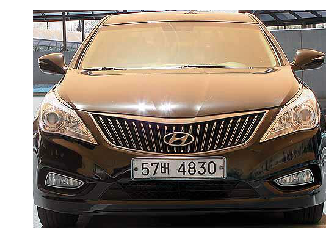

In [55]:
image = cv2.imread('data/image/example_car2.png')
plt.imshow(image)
plt.axis('off')
height, width, channels = image.shape

print('Shape : ', image.shape)

### 1-1. Gray 스케일로 변경

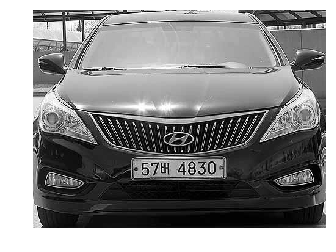

In [56]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap = 'gray')
plt.axis('off')

### 1-2. Blur 처리(잡티 제거)

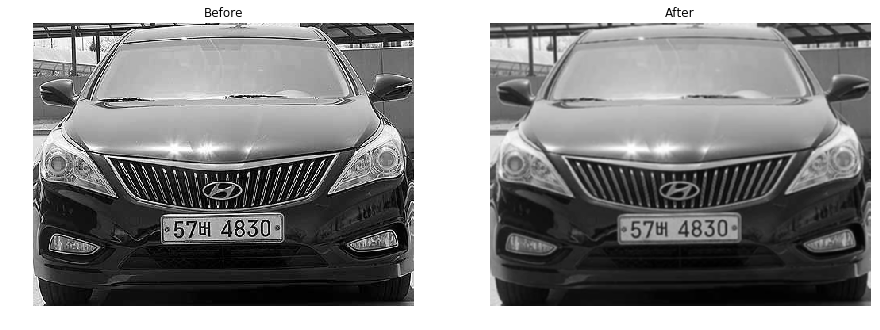

In [33]:
image_blur = cv2.GaussianBlur(image_gray, ksize=(5,5), sigmaX=0)

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(image_gray, cmap = 'gray')
plt.title('Before')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_blur, cmap = 'gray')
plt.title('After')
plt.axis('off')

plt.savefig('blog_image/License_no_DeepLearning/3_Blur_Compare.png',bbox_inches = 'tight', pad_inches=0)

### 1-3. Threshold 적용(임계값)

(-0.5, 479.5, 356.5, -0.5)

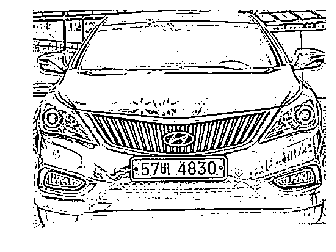

In [40]:
image_thresh = cv2.adaptiveThreshold(
    image_blur,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=7,
    C = 3
)

#image_thesh = cv2.GaussianBlur(image_thresh, ksize=(5,5), sigmaX=0)

plt.imshow(image_thresh, cmap='gray')
plt.axis('off')

## 2. 이미지 윤곽선 추출(Contour)

### 2-1. 윤곽선 찾기(find)

In [6]:
contours, _ = cv2.findContours(
    image=image_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

len(contours)

1038

### 2-1. 윤곽선 그리기

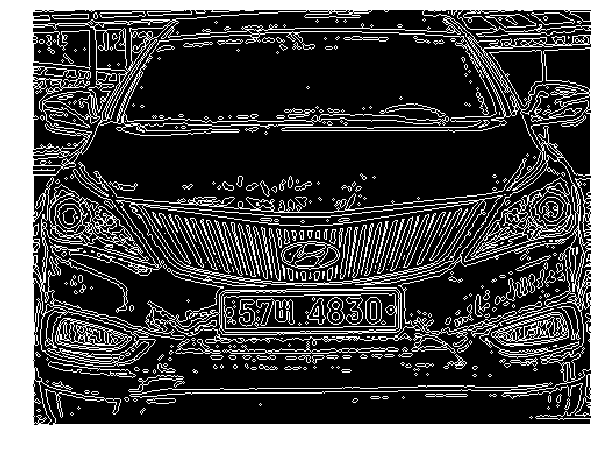

In [44]:
image_temp = np.zeros_like(image)
cv2.drawContours(image_temp, contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(10,10))
plt.imshow(image_temp)
plt.axis('off')

## 3. 윤곽선을 감싸는 사각형 추출

1038


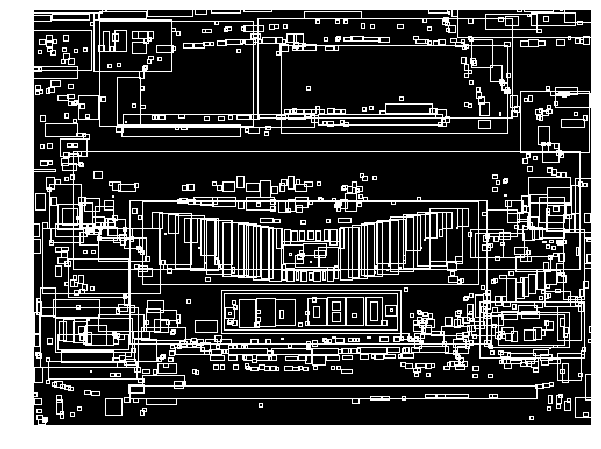

In [45]:
image_temp = np.zeros_like(image)

contours_list = []
for cont in contours:
    x, y, w, h = cv2.boundingRect(cont)
    rect_image = cv2.rectangle(image_temp, (x,y), (x+w, y+h), (255,255,255), 1)
    
    contours_list.append({
        'contour' : cont,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'cx' : x+w/2,
        'cy' : y+h/2
    })
    
print(len(contours_list))

plt.figure(figsize=(10,10))
plt.imshow(rect_image)
plt.axis('off')

## 4. 조건에 맞는 사각형 고르기
1. 숫자의 비율(0.3 < 가로/세로 < 1)
2. 가로, 세로의 최소 길이 == 2, 8 등등
3. 사각형의 최소 넓이 == 40 등등

In [9]:
def DrawRectangle(img_temp, cont_dict):
    x = cont_dict['x']
    y = cont_dict['y']
    w = cont_dict['w']
    h = cont_dict['h']
    rect_image = cv2.rectangle(img_temp, (x,y), (x+w,y+h), (255,255,255), 1)
    
    return rect_image

### 4-1. 숫자크기의 비율
- 0.3 < 가로/세로 < 1

In [10]:
matched_contours1 = []

for i, cont in enumerate(contours_list):
    if (cont['w']/cont['h'] < 1) and (cont['w']/cont['h'] > 0.3):
        matched_contours1.append(contours_list[i])

print(len(matched_contours1))

224


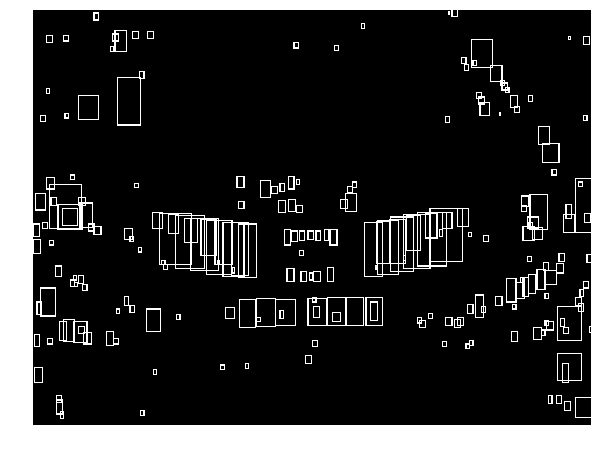

In [46]:
image_temp = np.zeros_like(image)
for cont in matched_contours1:
    rect_image = DrawRectangle(image_temp, cont)

plt.figure(figsize=(10,10))
plt.imshow(rect_image)
plt.axis('off')

### 4-2. 가로, 세로 최소 길이
- 가로 : 5
- 세로 : 15

In [12]:
matched_contours2 = []

for i, cont in enumerate(matched_contours1):
    if (cont['w'] > 5) & (cont['h'] > 15):
        matched_contours2.append(matched_contours1[i])
        
print(len(matched_contours2))

52


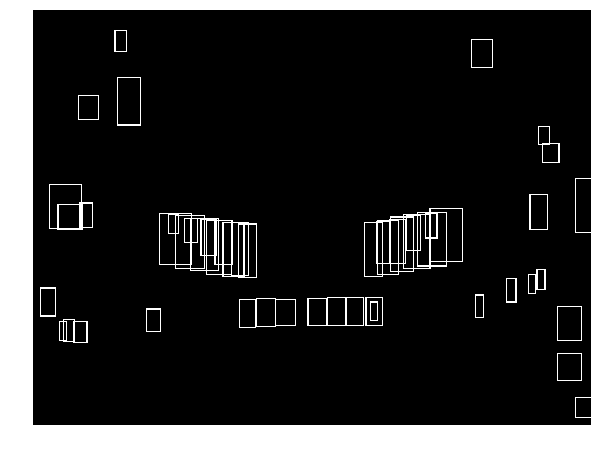

In [49]:
image_temp = np.zeros_like(image)
for cont in matched_contours2:
    rect_image = DrawRectangle(image_temp, cont)

plt.figure(figsize=(10,10))
plt.imshow(rect_image)
plt.axis('off')

## 5. 사각형의 배열을 통해 후보 선별
추출 된 사격형의 배열을 보고 번호판 숫자 골라내기
- 두 사격형의 중심의 거리 최대 10
- 두 사격형의 중심을 이었을 때, 높이 차(==각도)
- 면적의 차이(너무 많이 나면 인정 x)
- 가로의 차이
- 세로의 차이
- 만족하는 사격형의 집합을 뽑았을 때, 해당 집합 안에 7개가 포함되어 있는지
> **후보군을 형성하는 작업이라 한 번에 실행**

### 5-0. 각 사각형에 ID 부여하기
각각의 사각형을 쉽게 구별하기 위해 idx 추가

In [14]:
contour_list = []

for i, cont in enumerate(matched_contours2):
    cont['idx'] = i
    contour_list.append(cont)

### 5-1. 조건 만족1
1. 중심의 거리 차이
2. 각도 차이
3. 면적 차이 비율
4. 가로, 세로 차이 비율

In [15]:
matched_idx_list = []

MAX_DIST = 80
MAX_ANGLE = 12
MAX_AREA = 0.3
MAX_WIDTH = 0.3
MAX_HEIGHT = 0.3

for cont1 in contour_list:
    matched_idx = []
    matched_idx.append(cont1['idx'])
    for cont2 in contour_list:
        if cont1['idx'] == cont2['idx']:
            continue
            
        dx = abs(cont1['cx'] - cont2['cx'])
        dy = abs(cont1['cy'] - cont2['cy'])
        
        # 두 사각형의 중심의 거리
        dist = np.sqrt(dx**2 + dy**2)
        
        # 두 사각형의 각도 차
        if dx == 0:
            angle_dif = 90
        else:
            arctan = np.arctan(dy/dx)
            angle_dif = np.degrees(arctan)
            
        # 두 사각형의 면적 차이 비율
        area1 = cont1['w'] * cont1['h']
        area2 = cont2['w'] * cont2['h']
        
        area_dif = abs((area1 - area2)/area1)
        
        # 두 사각형 가로, 세로의 차
        width_dif = abs((cont1['w'] - cont2['w'])/cont1['w'])
        height_dif = abs((cont1['h'] - cont2['h'])/cont2['h'])
        
        if dist < MAX_DIST \
        and angle_dif < MAX_ANGLE \
        and area_dif < MAX_AREA \
        and width_dif < MAX_WIDTH \
        and height_dif < MAX_HEIGHT:
            matched_idx.append(cont2['idx'])
            
    matched_idx_list.append(matched_idx)

len(matched_idx_list)

52

### 5-2. 조건 만족2
- 후보가 7개인 것(번호판의 글자 개수)

In [16]:
final_matched = []
for m in matched_idx_list:
    if len(m) == 7:
        final_matched.append(m)
        
len(final_matched)

3

In [17]:
final_matched

[[8, 9, 10, 11, 12, 13, 14],
 [10, 8, 9, 11, 12, 13, 14],
 [14, 8, 9, 10, 11, 12, 13]]

### 5-3. 중복 제거
중복된 후보군 제거

In [18]:
license_idx_list = np.unique(final_matched)

In [19]:
license_idx_list

array([ 8,  9, 10, 11, 12, 13, 14])

### 5-4. idx -> Contour로 변환

In [20]:
license_list = np.take(contour_list, license_idx_list)

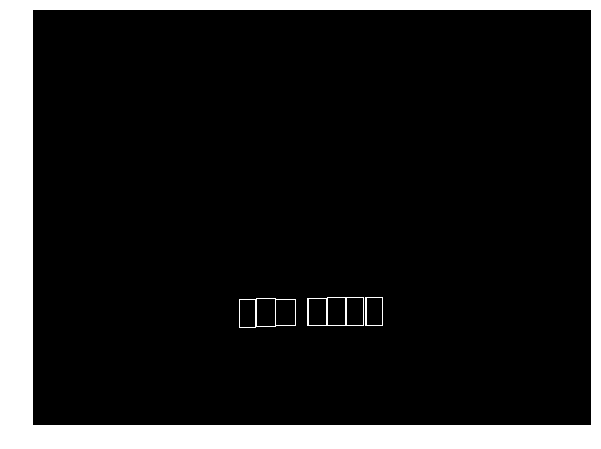

In [50]:
image_temp = np.zeros_like(image)

if type(license_list[0]) == dict:
    for cont in license_list:
        rect_image = DrawRectangle(image_temp, cont)
    plt.figure(figsize=(10,10))
    plt.imshow(rect_image)
    plt.axis('off')
    

        
else:
    for cont_list in license_list:
        for cont in cont_list:
            rect_image = DrawRectangle(image_temp, cont)
    plt.figure(figsize=(10,10))
    plt.imshow(rect_image)
    plt.axis('off')

6. 후보군의 모양이 휘어져있으면 다시 바로잡기(affine transfer)
7. 번호판 부분만 자른다.
8. 번호판 숫자가 맞는지 한 번 더 위 과정 실행
9. 숫자 인식을 위해 전처리
 - 블러
 - threshold딩
 - 윤곽선에 padding을 적용
10. pytesseract을 이용해 숫자 인식
11. 실제 이미지에서 번호판 부분 표시하기

## 6. 모양이 휘어져있으면 바로잡기
패쓰

## 7. 번호판 부분 자르기
- 결과가 1개라고 가정
- Padding을 사용해 번호판 영역 넉넉하게 구하기
- Contour을 이용해 가로, 세로 각각 구하기

In [60]:
PLATE_PADDING = 1.6

### 7-1. 번호판 중심, 가로, 세로 구하기

In [61]:
sorted_plate = sorted(license_list, key=lambda x: x['cx'])

plate_cx = (sorted_plate[-1]['cx'] + sorted_plate[0]['cx']) / 2
plate_cy = (sorted_plate[0]['cy'] + sorted_plate[-1]['cy']) / 2

plate_width = (sorted_plate[-1]['x'] - sorted_plate[0]['x'] + sorted_plate[-1]['w'])
plate_height = sorted_plate[3]['h'] * PLATE_PADDING

### 7-2. 자르기

(-0.5, 122.5, 35.5, -0.5)

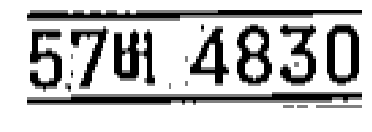

In [62]:
image_crop = cv2.getRectSubPix(
    image_thresh,
    patchSize=(int(plate_width), int(plate_height)),
    center=(int(plate_cx), int(plate_cy))
)

plt.imshow(image_crop, cmap='gray')
plt.axis('off')

## 8. 숫자 인식을 위한 전처리
- 깨끗하게 만들어줌
- Threshold 한 번 더 실행

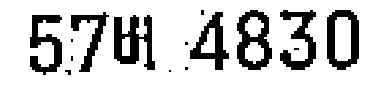

In [52]:
_, image_final = cv2.threshold(image_crop, thresh=125, maxval=255, type=cv2.THRESH_BINARY)
plt.imshow(image_final, cmap = 'gray')
plt.axis('off')

## 9. Pytesseract을 이용해 숫자인식

57버 4830


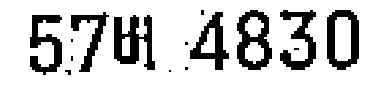

In [53]:
import pytesseract

result = pytesseract.image_to_string(image_final, lang='kor', config='--psm 7 --oem 0')

plt.imshow(image_final, cmap = 'gray')
plt.axis('off')
print(result)

## 10. 번호판 영역 표시하기

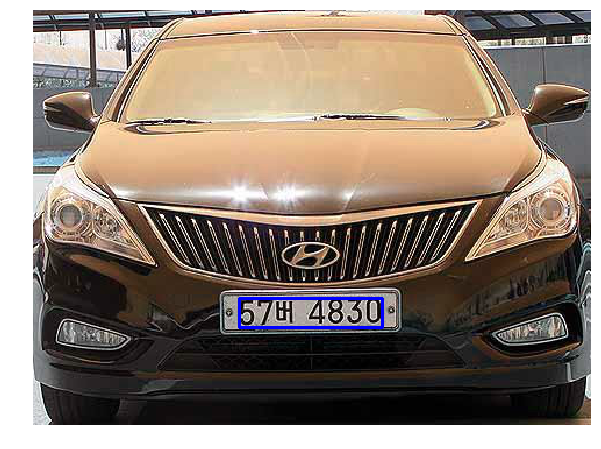

In [54]:
image_copy = image.copy()

image_copy = image.copy()
x = sorted_plate[0]['x']
y = sorted_plate[1]['y']


image_visual = cv2.rectangle(
    image_copy, 
    (x,y), 
    (x+int(plate_width), y+int(plate_height)), 
    color=(0,0,255),
    thickness=2
)

plt.figure(figsize=(10,10))
plt.imshow(image_visual)
plt.axis('off')